# Fase 1: Ingestão, Profiling e Limpeza de dados

In [ ]:
!pip install pandas requests python-dotenv pyarrow

In [ ]:
import os
import requests
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
import time

load_dotenv()
API_KEY = ""
BASE_URL = 'https://api.nasa.gov/neo/rest/v1/feed'


NUM_CALLS = 200
DAYS_PER_CALL = 7
TOTAL_DAYS = NUM_CALLS * DAYS_PER_CALL

all_asteroids = []

print(f"Iniciando a busca de dados dos últimos {TOTAL_DAYS} dias...")
print(f"Serão feitas {NUM_CALLS} chamadas à API, cada uma buscando {DAYS_PER_CALL} dias.")
print("-" * 30)

for i in range(NUM_CALLS):
    offset_days = i * DAYS_PER_CALL
    batch_end_date = datetime.now() - timedelta(days=offset_days)
    batch_start_date = batch_end_date - timedelta(days=DAYS_PER_CALL - 1)

    params = {
        'start_date': batch_start_date.strftime('%Y-%m-%d'),
        'end_date': batch_end_date.strftime('%Y-%m-%d'),
        'api_key': API_KEY
    }

    print(f"Lote {i+1}/{NUM_CALLS}: Buscando de {params['start_date']} até {params['end_date']}...")

    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        count_in_batch = 0
        for date_str, asteroids_on_date in data['near_earth_objects'].items():
            for asteroid in asteroids_on_date:
                all_asteroids.append(asteroid)
                count_in_batch += 1

        print(f"  -> Sucesso! {count_in_batch} aproximações encontradas neste lote.")

        if i < NUM_CALLS - 1:
            time.sleep(1)

    except requests.exceptions.RequestException as e:
        print(f"  -> ERRO ao buscar o lote: {e}")
        continue

print("-" * 30)
print("Busca em lotes concluída!")

if all_asteroids:
    df = pd.DataFrame(all_asteroids)

    filename = f"data/raw/neo_data_{TOTAL_DAYS}_days_{datetime.now().strftime('%Y-%m-%d')}.parquet"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    df.to_parquet(filename, index=False)
    print(f"\nDataset geral salvo com sucesso em: {filename}")
    print(f"Total de {len(df)} aproximações de asteroides únicas salvas.")
else:
    print("\nNenhum dado foi coletado. Verifique sua chave de API e conexão.")

Iniciando a busca de dados dos últimos 1400 dias...
Serão feitas 200 chamadas à API, cada uma buscando 7 dias.
------------------------------
Lote 1/200: Buscando de 2025-09-28 até 2025-10-04...
  -> Sucesso! 140 aproximações encontradas neste lote.
Lote 2/200: Buscando de 2025-09-21 até 2025-09-27...
  -> Sucesso! 151 aproximações encontradas neste lote.
Lote 3/200: Buscando de 2025-09-14 até 2025-09-20...
  -> Sucesso! 127 aproximações encontradas neste lote.
Lote 4/200: Buscando de 2025-09-07 até 2025-09-13...
  -> Sucesso! 135 aproximações encontradas neste lote.
Lote 5/200: Buscando de 2025-08-31 até 2025-09-06...
  -> Sucesso! 118 aproximações encontradas neste lote.
Lote 6/200: Buscando de 2025-08-24 até 2025-08-30...
  -> Sucesso! 123 aproximações encontradas neste lote.
Lote 7/200: Buscando de 2025-08-17 até 2025-08-23...
  -> Sucesso! 118 aproximações encontradas neste lote.
Lote 8/200: Buscando de 2025-08-10 até 2025-08-16...
  -> Sucesso! 110 aproximações encontradas neste 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25950 entries, 0 to 25949
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   links                              25950 non-null  object 
 1   id                                 25950 non-null  object 
 2   neo_reference_id                   25950 non-null  object 
 3   name                               25950 non-null  object 
 4   nasa_jpl_url                       25950 non-null  object 
 5   absolute_magnitude_h               25950 non-null  float64
 6   estimated_diameter                 25950 non-null  object 
 7   is_potentially_hazardous_asteroid  25950 non-null  bool   
 8   close_approach_data                25950 non-null  object 
 9   is_sentry_object                   25950 non-null  bool   
 10  sentry_data                        1662 non-null   object 
dtypes: bool(2), float64(1), object(8)
memory usage: 1.8+ M

In [ ]:
df.describe()

,absolute_magnitude_h
count,25950.000000
mean,24.583957
std,2.538068
min,13.810000
25%,22.980000
50%,24.800000
75%,26.350000
max,32.950000


In [ ]:
df.head()

,links,id,neo_reference_id,name,nasa_jpl_url,absolute_magnitude_h,estimated_diameter,is_potentially_hazardous_asteroid,close_approach_data,is_sentry_object,sentry_data
0,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,3427459,3427459,(2008 SS),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,22.18,{'kilometers': {'estimated_diameter_min': 0.09...,False,"[{'close_approach_date': '2025-10-03', 'close_...",False,NaN
1,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,3716631,3716631,(2015 HN9),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,22.60,{'kilometers': {'estimated_diameter_min': 0.08...,False,"[{'close_approach_date': '2025-10-03', 'close_...",False,NaN
2,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,3720000,3720000,(2015 KT120),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,25.10,{'kilometers': {'estimated_diameter_min': 0.02...,False,"[{'close_approach_date': '2025-10-03', 'close_...",False,NaN
3,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,54201807,54201807,(2021 SY3),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,27.00,{'kilometers': {'estimated_diameter_min': 0.01...,False,"[{'close_approach_date': '2025-10-03', 'close_...",False,NaN
4,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,54212590,54212590,(2021 UJ1),https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,26.33,{'kilometers': {'estimated_diameter_min': 0.01...,False,"[{'close_approach_date': '2025-10-03', 'close_...",False,NaN


### Analise dos dados retirados da API

In [ ]:
import pandas as pd

df = pd.read_parquet('data/raw/')

print("--- Informações Gerais do DataFrame ---")
df.info()

print("\n--- 5 Primeiras Linhas ---")
print(df.head())

print("\n--- Resumo Estatístico das Colunas Numéricas ---")
print(df.describe().apply(lambda s: s.apply('{:,.2f}'.format)))

--- Informações Gerais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25950 entries, 0 to 25949
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   links                              25950 non-null  object 
 1   id                                 25950 non-null  object 
 2   neo_reference_id                   25950 non-null  object 
 3   name                               25950 non-null  object 
 4   nasa_jpl_url                       25950 non-null  object 
 5   absolute_magnitude_h               25950 non-null  float64
 6   estimated_diameter                 25950 non-null  object 
 7   is_potentially_hazardous_asteroid  25950 non-null  bool   
 8   close_approach_data                25950 non-null  object 
 9   is_sentry_object                   25950 non-null  bool   
 10  sentry_data                        1662 non-null   object 
dtypes: bool(2), fl

df.info(): Mostra as colunas, quantos valores não-nulos existem em cada uma e qual o tipo de dado. Aqui já podemos ver colunas com muitos dados faltando ou colunas que deveriam ser numéricas mas são object.

df.head(): Mostra que os dados parecem aninhados.

df.describe(): Revela a escala dos dados. Podemos ver o diâmetro médio, máximo e mínimo dos asteroides, a velocidade, etc. É aqui que detectamos outliers grosseiros (por exemplo, um valor máximo estranhamente alto).

### Organização de dados

In [ ]:
df_diameters = df['estimated_diameter'].apply(lambda x: x['kilometers']).apply(pd.Series)
df_diameters = df_diameters.rename(columns={
    'estimated_diameter_min': 'diameter_km_min',
    'estimated_diameter_max': 'diameter_km_max'
})

df_approach = df['close_approach_data'].apply(lambda x: x[0]).apply(pd.Series)
df_approach_velocity = df_approach['relative_velocity'].apply(pd.Series)
df_approach_distance = df_approach['miss_distance'].apply(pd.Series)

df_clean = pd.concat([
    df[['id', 'name', 'absolute_magnitude_h', 'is_potentially_hazardous_asteroid']],
    df_diameters[['diameter_km_min', 'diameter_km_max']],
    df_approach[['close_approach_date']],
    df_approach_velocity[['kilometers_per_second']],
    df_approach_distance[['kilometers']]
], axis=1)

df_clean = df_clean.rename(columns={
    'is_potentially_hazardous_asteroid': 'is_pha',
    'kilometers_per_second': 'velocity_km_s',
    'kilometers': 'miss_distance_km'
})


df_clean['close_approach_date'] = pd.to_datetime(df_clean['close_approach_date'])
numeric_cols = ['diameter_km_min', 'diameter_km_max', 'velocity_km_s', 'miss_distance_km']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col])

print("\n--- Informações do DataFrame Limpo ---")
df_clean.info()

print("\n--- Contagem de Valores Ausentes ---")
print(df_clean.isnull().sum())

clean_filename = f"data/processed/neo_data_clean_{datetime.now().strftime('%Y-%m-%d')}.parquet"
os.makedirs(os.path.dirname(clean_filename), exist_ok=True)
df_clean.to_parquet(clean_filename, index=False)
print(f"\nDataFrame limpo e processado salvo em: {clean_filename}")


--- Informações do DataFrame Limpo ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25950 entries, 0 to 25949
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    25950 non-null  object        
 1   name                  25950 non-null  object        
 2   absolute_magnitude_h  25950 non-null  float64       
 3   is_pha                25950 non-null  bool          
 4   diameter_km_min       25950 non-null  float64       
 5   diameter_km_max       25950 non-null  float64       
 6   close_approach_date   25950 non-null  datetime64[ns]
 7   velocity_km_s         25950 non-null  float64       
 8   miss_distance_km      25950 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(5), object(2)
memory usage: 1.6+ MB

--- Contagem de Valores Ausentes ---
id                      0
name                    0
absolute_magnitude_h    0
is_pha            

# Análise Exploratória de Dados

- Análise Univariada
- Análise Bivariada e Multivariada

In [ ]:
!pip install matplotlib seaborn

## Limpando mais o dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

file_date = datetime.now().strftime('%Y-%m-%d')
try:
    df_clean = pd.read_parquet(f'data/processed/neo_data_clean_{file_date}.parquet')
except FileNotFoundError:
    df_clean = pd.read_parquet(f'data/processed/neo_data_last_30_days_{file_date}.parquet')

print(f"Total de registros: {len(df_clean)}")
df_clean.head()

DataFrame limpo carregado com sucesso!
Total de registros: 25950


,id,name,absolute_magnitude_h,is_pha,diameter_km_min,diameter_km_max,close_approach_date,velocity_km_s,miss_distance_km
0,3427459,(2008 SS),22.18,False,0.097399,0.217791,2025-10-03,14.527860,1.786059e+07
1,3716631,(2015 HN9),22.60,False,0.080270,0.179490,2025-10-03,7.708430,1.230767e+07
2,3720000,(2015 KT120),25.10,False,0.025384,0.056760,2025-10-03,11.569204,3.982755e+07
3,54201807,(2021 SY3),27.00,False,0.010582,0.023661,2025-10-03,5.929401,7.782742e+06
4,54212590,(2021 UJ1),26.33,False,0.014406,0.032214,2025-10-03,22.126147,6.674091e+07


### Análise Univariada

1. Qual é a distribuição do tamanho dos asteroides?

- Pergunta: Temos mais asteroides grandes ou pequenos? A distribuição é uniforme?

- Hipótese: Esperamos encontrar muitos objetos pequenos e poucos objetos grandes.


2. Qual a proporção de asteroides potencialmente perigosos (PHA)?

- Pergunta: Do total de objetos que se aproximam, quantos realmente representam um risco segundo a classificação oficial?

- Hipótese: A maioria não deve ser classificada como perigosa.

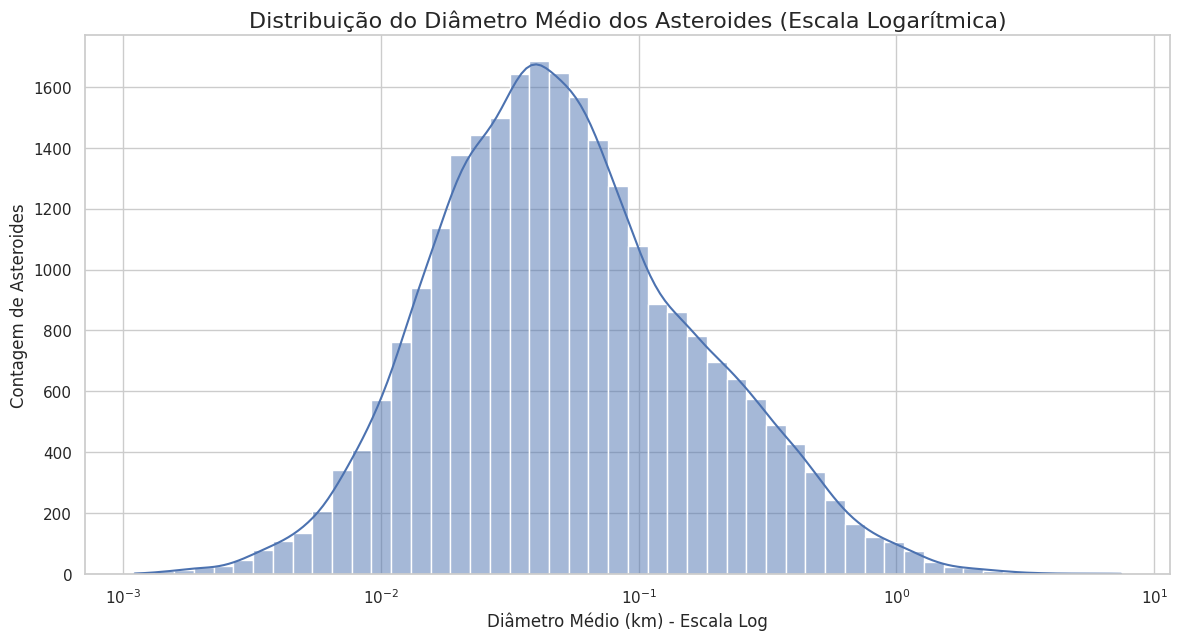

In [ ]:
df_clean['diameter_km_avg'] = (df_clean['diameter_km_min'] + df_clean['diameter_km_max']) / 2

plt.figure(figsize=(14, 7))
sns.histplot(df_clean['diameter_km_avg'], bins=50, kde=True, log_scale=True)
plt.title('Distribuição do Diâmetro Médio dos Asteroides (Escala Logarítmica)', fontsize=16)
plt.xlabel('Diâmetro Médio (km) - Escala Log', fontsize=12)
plt.ylabel('Contagem de Asteroides', fontsize=12)
plt.show()

/tmp/ipython-input-2653254565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pha_counts.index, y=pha_counts.values, palette=['skyblue', 'salmon'])


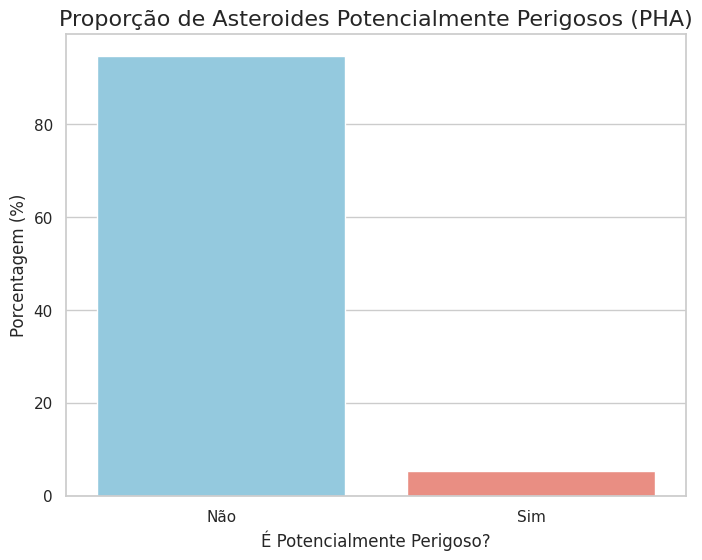

Porcentagem de PHAs: 5.24%


In [ ]:
plt.figure(figsize=(8, 6))
pha_counts = df_clean['is_pha'].value_counts(normalize=True) * 100
sns.barplot(x=pha_counts.index, y=pha_counts.values, palette=['skyblue', 'salmon'])
plt.title('Proporção de Asteroides Potencialmente Perigosos (PHA)', fontsize=16)
plt.xlabel('É Potencialmente Perigoso?', fontsize=12)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()

print(f"Porcentagem de PHAs: {pha_counts[True]:.2f}%")

### Análise Bivariada (Entendendo as relações)

1. Asteroides maiores são mais rápidos?
- Pergunta: Existe uma relação entre o tamanho de um asteroide e a velocidade com que ele passa pela Terra?

- Hipótese: Não deve haver uma correlação óbvia. A velocidade depende mais da órbita do que do tamanho.

2. Qual a relação geral entre todas as variáveis numéricas?

- Pergunta: De uma vez só, como todas as nossas variáveis numéricas se correlacionam umas com as outras?

- Hipótese: Esperamos ver algumas correlações fortes e óbvias (como diâmetro mínimo e máximo) e talvez algumas mais sutis.

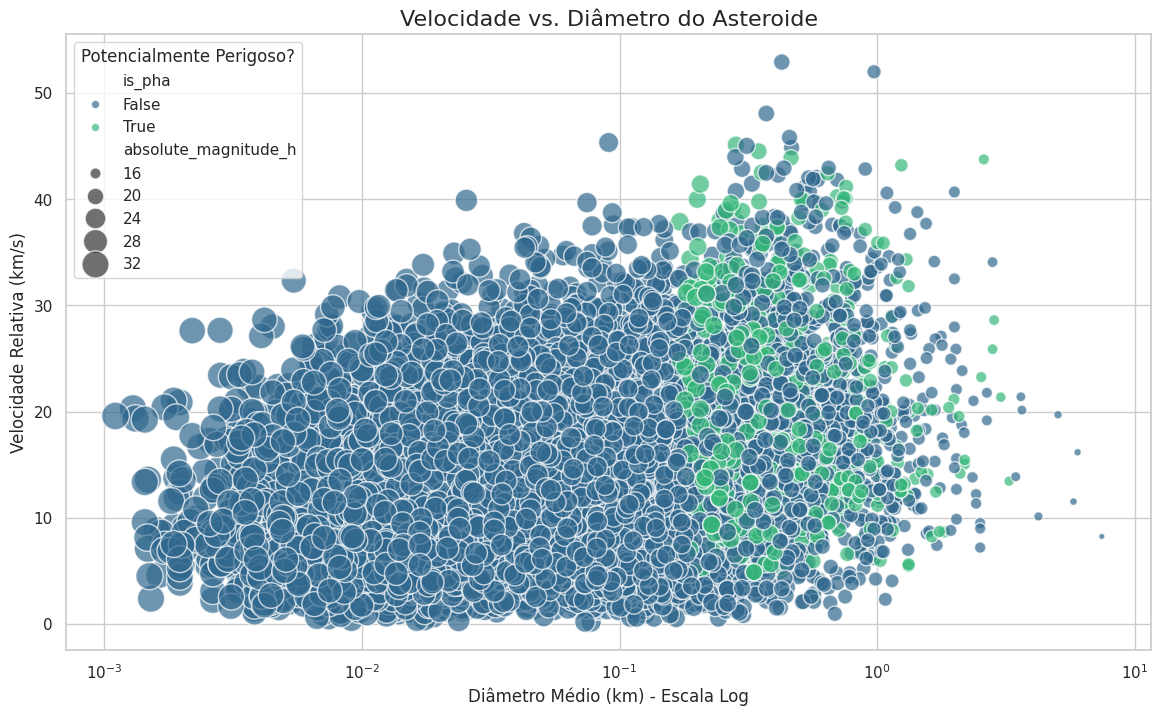

In [ ]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df_clean,
    x='diameter_km_avg',
    y='velocity_km_s',
    hue='is_pha',
    palette='viridis',
    alpha=0.7,
    size='absolute_magnitude_h',
    sizes=(20, 400)
)
plt.xscale('log')
plt.title('Velocidade vs. Diâmetro do Asteroide', fontsize=16)
plt.xlabel('Diâmetro Médio (km) - Escala Log', fontsize=12)
plt.ylabel('Velocidade Relativa (km/s)', fontsize=12)
plt.legend(title='Potencialmente Perigoso?')
plt.show()

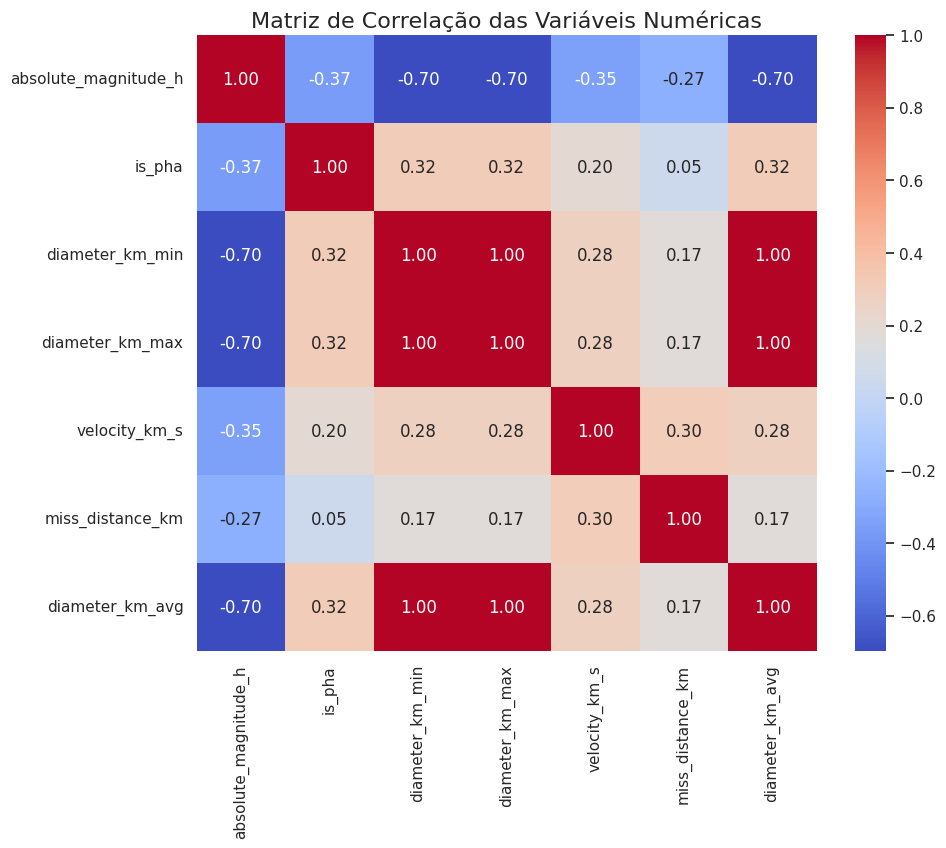

In [ ]:
# Selecionar apenas as colunas numéricas para a matriz de correlação
numeric_df = df_clean.select_dtypes(include=['float64', 'int64', 'bool'])

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16)
plt.show()

# Análises de potências riscos

In [ ]:
import numpy as np


DENSIDADE_ASTEROIDE_KG_M3 = 2000


for col in ['diameter_km_avg', 'velocity_km_s']:
    median_val = df_clean[col].median()
    df_clean[col].fillna(median_val, inplace=True)


raio_m = (df_clean['diameter_km_avg'] * 1000) / 2

volume_m3 = (4/3) * np.pi * (raio_m ** 3)

massa_kg = DENSIDADE_ASTEROIDE_KG_M3 * volume_m3

velocidade_m_s = df_clean['velocity_km_s'] * 1000

df_clean['kinetic_energy_joules'] = 0.5 * massa_kg * (velocidade_m_s ** 2)

print("Top 5 asteroides por energia cinética")
print(df_clean.sort_values('kinetic_energy_joules', ascending=False)[['name', 'kinetic_energy_joules']].head())

Coluna 'kinetic_energy_joules' criada com sucesso!
Top 5 asteroides por energia cinética:
                       name  kinetic_energy_joules
10973   1685 Toro (1948 OA)           2.946227e+22
23990     137170 (1999 HF1)           2.588041e+22
17274      523630 (2009 OG)           1.744423e+22
4298   887 Alinda (A918 AA)           1.466889e+22
5476       66146 (1998 TU3)           1.340478e+22


/tmp/ipython-input-2644680455.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)


## Modelo ML

In [ ]:
from sklearn.model_selection import train_test_split

features = [
    'absolute_magnitude_h',
    'diameter_km_avg',
    'velocity_km_s',
    'miss_distance_km',
    'kinetic_energy_joules'
]

X = df_clean[features]
y = df_clean['is_pha']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dados de treino: {X_train.shape[0]} amostras")
print(f"Dados de teste:  {X_test.shape[0]} amostras")

Dados de treino: 20760 amostras
Dados de teste:  5190 amostras


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

model.fit(X_train, y_train)

print("treinado com sucesso!")

Modelo Random Forest treinado com sucesso!



--- Relatório de Classificação ---
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      4918
        True       0.66      0.37      0.47       272

    accuracy                           0.96      5190
   macro avg       0.81      0.68      0.73      5190
weighted avg       0.95      0.96      0.95      5190


--- Matriz de Confusão ---


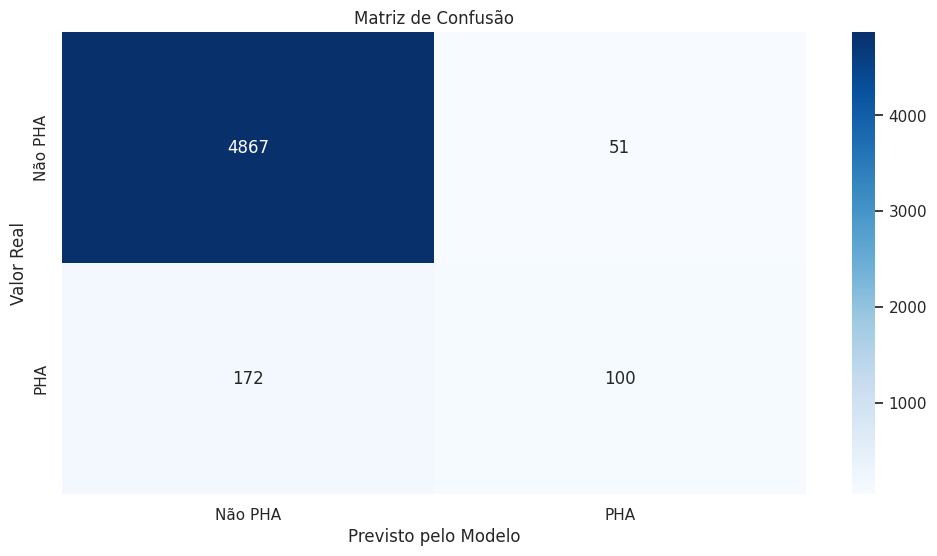

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não PHA', 'PHA'], yticklabels=['Não PHA', 'PHA'])
plt.xlabel('Previsto pelo Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

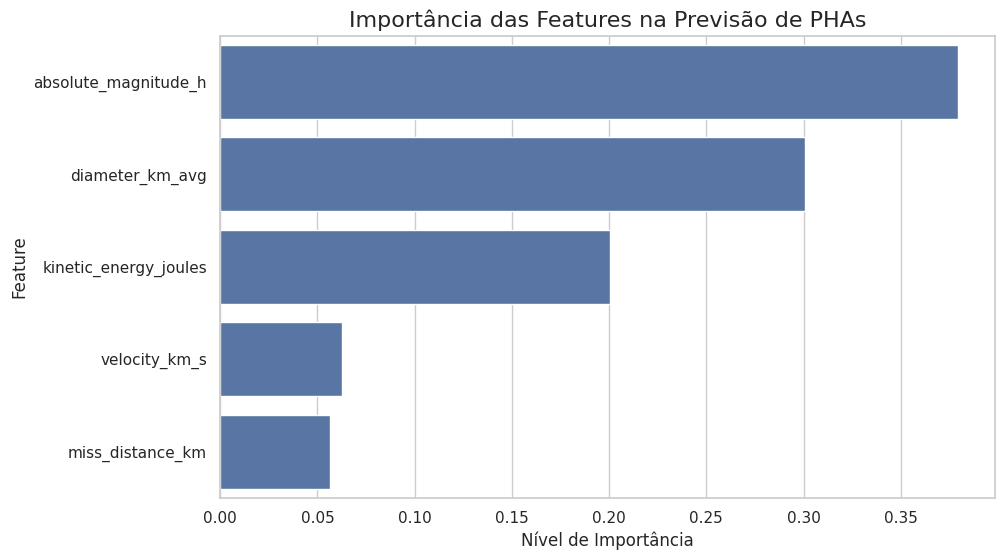

In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Importância das Features na Previsão de PHAs', fontsize=16)
plt.xlabel('Nível de Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [ ]:
import joblib
import os

model_path = 'ml_models/'
model_filename = 'pha_classifier.pkl'
full_path = os.path.join(model_path, model_filename)

os.makedirs(model_path, exist_ok=True)

joblib.dump(model, full_path)

print(f"Modelo salvo com sucesso em: {full_path}")

Modelo salvo com sucesso em: ml_models/pha_classifier.pkl


## Simulação de impacto - TESTE

In [ ]:
try:
    asteroid_type = simulated_request.get("asteroid_type", "Rochoso")
    scenario_params = SCENARIOS.get(asteroid_type)
    engine_args = {
        "diameter_km": simulated_request["diameter_km"], "velocity_km_s": simulated_request["velocity_km_s"],
        "impact_angle": simulated_request["impact_angle"], "densidade_rho": scenario_params["densidade_rho"],
        "eficiencia_eta": scenario_params["eficiencia_eta"]
    }
    simulation_results = calculate_damage_from_pair_model(**engine_args)

    ml_features = {
        'absolute_magnitude_h': 22.0, 'diameter_km_avg': simulated_request["diameter_km"],
        'velocity_km_s': simulated_request["velocity_km_s"], 'miss_distance_km': 10000000,
        'kinetic_energy_joules': simulation_results['kinetic_energy_joules']
    }
    pha_prediction = predict_pha_risk(ml_features)

    CATASTROPHIC_THRESHOLD_MT = 1000
    final_pha_risk = pha_prediction
    risk_source = "Machine Learning"

    if simulation_results['energia_megatons'] > CATASTROPHIC_THRESHOLD_MT:
        final_pha_risk = True
        risk_source = "Regra de Segurança de Física (Energia Extrema)"

    simulation_results['is_pha_prediction'] = final_pha_risk
    simulation_results['risk_assessment_source'] = risk_source

    llm_report = f"Relatório de IA: Impacto simulado. Risco de PHA previsto: {final_pha_risk} (Fonte: {risk_source}). Energia: {simulation_results['energia_megatons']} MT. Dano final: {simulation_results['raio_dano_final_km']} km."
    final_result = {
        "input_params": simulated_request, "scenario_params": scenario_params,
        "simulation_output": simulation_results, "llm_report": llm_report
    }

    print(json.dumps(final_result, indent=2))

except Exception as e:
    print(f"{e}")


🚀 Iniciando simulação de teste no Colab...
✅ Simulação concluída com sucesso!

--- RESULTADO FINAL DA SIMULAÇÃO (JSON) ---
{
  "input_params": {
    "diameter_km": 0.4,
    "velocity_km_s": 25,
    "impact_angle": 60,
    "impact_lat": -10.997,
    "impact_lng": -37.05,
    "asteroid_type": "Met\u00e1lico"
  },
  "scenario_params": {
    "densidade_rho": 7500,
    "eficiencia_eta": 0.0005
  },
  "simulation_output": {
    "energia_megatons": 16256.57,
    "altitude_explosao_km": 0.0,
    "raio_dano_explosao_km": 128.69,
    "raio_dano_termico_km": 0.78,
    "raio_dano_final_km": 128.69,
    "kinetic_energy_joules": 6.801747615878317e+19,
    "is_pha_prediction": true,
    "risk_assessment_source": "Regra de Seguran\u00e7a de F\u00edsica (Energia Extrema)"
  },
  "llm_report": "Relat\u00f3rio de IA: Impacto simulado. Risco de PHA previsto: True (Fonte: Regra de Seguran\u00e7a de F\u00edsica (Energia Extrema)). Energia: 16256.57 MT. Dano final: 128.69 km."
}


In [ ]:
import joblib
import pandas as pd
import numpy as np
import json

MODEL_PATH = "ml_models/pha_classifier.pkl"
try:
    PHA_CLASSIFIER_MODEL = joblib.load(MODEL_PATH)
    print("Modelo de ML carregado com sucesso!")
except FileNotFoundError:
    print(f" Arquivo do modelo '{MODEL_PATH}' não encontrado.")
    PHA_CLASSIFIER_MODEL = None

SCENARIOS = {
    "Rochoso": {"densidade_rho": 3000, "eficiencia_eta": 0.001},
    "Metálico": {"densidade_rho": 7500, "eficiencia_eta": 0.0005},
    "Cometa": {"densidade_rho": 1100, "eficiencia_eta": 0.003}
}

def calculate_damage_from_pair_model(diameter_km, velocity_km_s, impact_angle, densidade_rho, eficiencia_eta):
    raio_m = (diameter_km * 1000) / 2
    velocidade_m_s = velocity_km_s * 1000
    volume_m3 = (4/3) * np.pi * (raio_m ** 3)
    massa_kg = densidade_rho * volume_m3
    energia_cinetica_j = 0.5 * massa_kg * (velocidade_m_s ** 2) * np.sin(np.radians(impact_angle))
    energia_E_megatons = energia_cinetica_j / 4.184e15

    altitude_h_km = 5.0 if diameter_km < 0.05 else 0.0
    E, h, eta = energia_E_megatons, altitude_h_km, eficiencia_eta

    raio_blast_km = (5.08 * (E**(1/3))) if h == 0 else ((2.09 * (h**-0.449) * (h**2) * (E**(-1/3))) + (5.08 * (E**(1/3))))
    Zi = 0.42 * (E**(1/6))
    r_sq = (eta * E) / (2 * np.pi * Zi)
    h_sq = h**2
    raio_thermal_km = np.sqrt(r_sq - h_sq) if r_sq > h_sq else 0.0

    return {
        "energia_megatons": round(E, 2), "altitude_explosao_km": round(h, 2),
        "raio_dano_explosao_km": round(raio_blast_km, 2), "raio_dano_termico_km": round(raio_thermal_km, 2),
        "raio_dano_final_km": round(max(raio_blast_km, raio_thermal_km), 2), "kinetic_energy_joules": energia_cinetica_j
    }

def predict_pha_risk(features_dict):
    if not PHA_CLASSIFIER_MODEL: return None
    features_order = ['absolute_magnitude_h', 'diameter_km_avg', 'velocity_km_s', 'miss_distance_km', 'kinetic_energy_joules']
    input_df = pd.DataFrame([features_dict], columns=features_order)
    prediction = PHA_CLASSIFIER_MODEL.predict(input_df)
    return bool(prediction[0])


simulated_request = {
  "diameter_km": 0.4,
  "velocity_km_s": 25,
  "impact_angle": 60,
  "impact_lat": -10.997,
  "impact_lng": -37.05,
  "asteroid_type": "Metálico"
}

try:
    asteroid_type = simulated_request.get("asteroid_type", "Rochoso")
    scenario_params = SCENARIOS.get(asteroid_type)

    engine_args = {
        "diameter_km": simulated_request["diameter_km"], "velocity_km_s": simulated_request["velocity_km_s"],
        "impact_angle": simulated_request["impact_angle"], "densidade_rho": scenario_params["densidade_rho"],
        "eficiencia_eta": scenario_params["eficiencia_eta"]
    }

    simulation_results = calculate_damage_from_pair_model(**engine_args)

    ml_features = {
        'absolute_magnitude_h': 22.0, 'diameter_km_avg': simulated_request["diameter_km"],
        'velocity_km_s': simulated_request["velocity_km_s"], 'miss_distance_km': 10000000,
        'kinetic_energy_joules': simulation_results['kinetic_energy_joules']
    }

    pha_prediction = predict_pha_risk(ml_features)
    simulation_results['is_pha_prediction'] = pha_prediction

    llm_report = f"Relatório de IA: Impacto simulado. Risco de PHA previsto: {pha_prediction}. Energia: {simulation_results['energia_megatons']} MT. Dano final: {simulation_results['raio_dano_final_km']} km."

    final_result = {
        "input_params": simulated_request, "scenario_params": scenario_params,
        "simulation_output": simulation_results, "llm_report": llm_report
    }

    print(json.dumps(final_result, indent=2))

except Exception as e:
    print(f"{e}")

✅ Modelo de ML carregado com sucesso!

🚀 Iniciando simulação de teste no Colab...
✅ Simulação concluída com sucesso!

--- RESULTADO FINAL DA SIMULAÇÃO (JSON) ---
{
  "input_params": {
    "diameter_km": 0.4,
    "velocity_km_s": 25,
    "impact_angle": 60,
    "impact_lat": -10.997,
    "impact_lng": -37.05,
    "asteroid_type": "Met\u00e1lico"
  },
  "scenario_params": {
    "densidade_rho": 7500,
    "eficiencia_eta": 0.0005
  },
  "simulation_output": {
    "energia_megatons": 16256.57,
    "altitude_explosao_km": 0.0,
    "raio_dano_explosao_km": 128.69,
    "raio_dano_termico_km": 0.78,
    "raio_dano_final_km": 128.69,
    "kinetic_energy_joules": 6.801747615878317e+19,
    "is_pha_prediction": false
  },
  "llm_report": "Relat\u00f3rio de IA: Impacto simulado. Risco de PHA previsto: False. Energia: 16256.57 MT. Dano final: 128.69 km."
}
